## House Prediction Multiple Regression Analysis

# Introduction

Understanding the factors that influence house prices is critical for stakeholders in the real estate market, including buyers, sellers, and policymakers. This project utilizes the House Prices in King County, USA dataset from Kaggle, which contains comprehensive information on house sales in King County, Washington. The dataset includes 21,613 observations and 19 features such as house attributes (square footage, number of bedrooms, and bathrooms), location-based characteristics ( zip code and proximity to waterfronts), and time of sale.

The primary objective of this project is to explore the key predictors of house prices and develop a robust predictive model. By analyzing trends and patterns in the data, we aim to provide insights into how various factors contribute to housing prices and their implications for the local real estate market. In addition, the study investigates potential systemic trends, such as the impact of location and property features on price variance.

The project adopts a comprehensive approach to data preprocessing, exploratory data analysis, and advanced modeling techniques to deliver actionable insights and practical recommendations for stakeholders.


In [98]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro, levene
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import boxcox
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import boxcox_llf


In [81]:

# Load the dataset
kc_house_data = pd.read_csv(r"C:\Users\EWURA\Downloads\Stat 563 Project\kc_house_data.csv")

# View the first few rows
print(kc_house_data.head())


           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7      1180.0              0   
1      7242     2.0           0     0  ...      7      2170.0            400   
2     10000     1.0           0     0  ...      6       770.0              0   
3      5000     1.0           0     0  ...      7      1050.0            910   
4      8080     1.0           0     0  ...      8      1680.0              0   

   yr_built  yr_renovated  zipcode      lat     lo

In [82]:
# Check structure (data types of columns)
print(kc_house_data.info())

# Check summary statistics
print(kc_house_data.describe())

# Check for missing values
print(kc_house_data.isna().sum())

# Check for duplicate rows
num_duplicates = kc_house_data.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [83]:
# Convert 'date' to datetime type
kc_house_data['date'] = pd.to_datetime(kc_house_data['date'], format='%Y%m%dT%H%M%S')

# Convert categorical-like columns to category type
kc_house_data['waterfront'] = kc_house_data['waterfront'].astype('category')
kc_house_data['view'] = kc_house_data['view'].astype('category')
kc_house_data['condition'] = kc_house_data['condition'].astype('category')
kc_house_data['grade'] = kc_house_data['grade'].astype('category')

# Verify the changes
print(kc_house_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  category      
 9   view           21613 non-null  category      
 10  condition      21613 non-null  category      
 11  grade          21613 non-null  category      
 12  sqft_above     21611 non-null  float64       
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

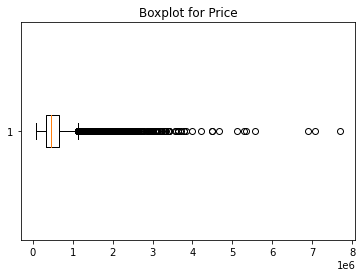

In [84]:
# Boxplot for price
plt.boxplot(kc_house_data['price'], vert=False)
plt.title("Boxplot for Price")
plt.show()

In [85]:
# Filter out extreme values
kc_house_data = kc_house_data[(kc_house_data['bedrooms'] <= 10) & 
                              (kc_house_data['sqft_lot'] < kc_house_data['sqft_lot'].quantile(0.99))]


In [86]:
# Ensure pandas datetime functionality is imported
from pandas import to_datetime

# Extracting year and month from the date column
kc_house_data['year_sold'] = kc_house_data['date'].dt.year
kc_house_data['month_sold'] = kc_house_data['date'].dt.month

# Grouping yr_built into decades
kc_house_data['decade_built'] = (kc_house_data['yr_built'] // 10) * 10

# Verify the changes
print(kc_house_data[['year_sold', 'month_sold', 'decade_built']].head())


   year_sold  month_sold  decade_built
0       2014          10          1950
1       2014          12          1950
2       2015           2          1930
3       2014          12          1960
4       2015           2          1980


We filters out rows where the number of bedrooms exceeds 10; since this is an unusual case in real life. Not that we can have such a situation, but it is rare.
The 99th percentile here means we exclude only the top 1% of data points. These values are often outliers that represent unusually  rare lot sizes that can distort statistical analysis.
By keeping 99% of the data, we retain almost all the observations while removing extreme values that may heavily influence the results.



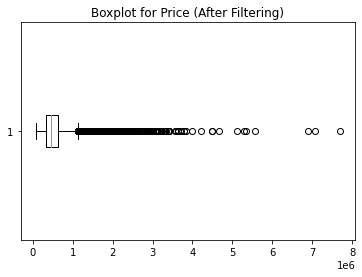

Correlation between sqft_lot and price: 0.11206929246381842


In [87]:
# Recheck outliers after filtering
plt.boxplot(kc_house_data['price'], vert=False)
plt.title("Boxplot for Price (After Filtering)")
plt.show()

# Correlation between sqft_lot and price
correlation = kc_house_data['sqft_lot'].corr(kc_house_data['price'])
print(f"Correlation between sqft_lot and price: {correlation}")



The correlation between sqft_lot and price is 0.1120, thus a weak positive relationship. 
Given this weak positive correlation (0.1120) between sqft_lot and price, filtering based on sqft_lot does not significantly impact outliers in price. This is the reason why the boxplots for price displayed above remain unchanged even after filtering.


(20257, 24)


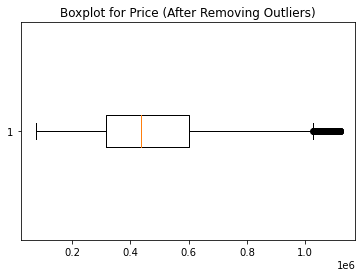

In [61]:
# Calculate IQR for price
Q1 = kc_house_data['price'].quantile(0.25)
Q3 = kc_house_data['price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for price
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows within bounds
kc_house_data = kc_house_data[(kc_house_data['price'] >= lower_bound) & (kc_house_data['price'] <= upper_bound)]

# Verify the filtering
print(kc_house_data.shape)

# Recheck boxplot for price
plt.boxplot(kc_house_data['price'], vert=False)
plt.title("Boxplot for Price (After Removing Outliers)")
plt.show()


## Exploratory Data Analysis

The IQR method is a common approach for dealing with outliers. It is not sufficient for this dataset due to the large range and skewness of price.
The price variable is heavily skewed,hence we apply a log transformation to stabilize the variability and make the distribution more symmetric.


count    2.025700e+04
mean     4.755098e+05
std      2.075708e+05
min      7.500000e+04
25%      3.150000e+05
50%      4.350000e+05
75%      6.000000e+05
max      1.120280e+06
Name: price, dtype: float64
count    20257.000000
mean      1968.781113
std        769.049943
min        290.000000
25%       1400.000000
50%       1850.000000
75%       2430.000000
max       7480.000000
Name: sqft_living, dtype: float64


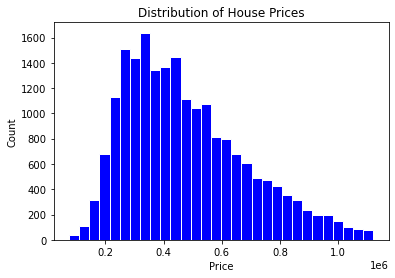

In [62]:
# Summary statistics for price
print(kc_house_data['price'].describe())

# Summary statistics for sqft_living
print(kc_house_data['sqft_living'].describe())

# Histogram for house prices
plt.hist(kc_house_data['price'], bins=30, color='blue', edgecolor='white')
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


The histogram above illustrates the distribution of house prices in King County. 
The distribution is right-skewed, with the majority of houses priced below $500,000. This suggests that most properties fall within a mid-range price category, while fewer properties are available at higher price points, with a long tail extending towards more expensive homes. 


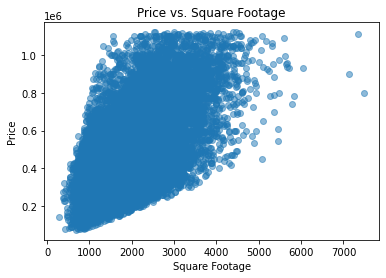

In [63]:

# Scatter plot for Price vs. Square Footage
plt.scatter(kc_house_data['sqft_living'], kc_house_data['price'], alpha=0.5)
plt.title("Price vs. Square Footage")
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.show()


The scatterplot shows the relationship between house prices and square footage in King County. There is a clear positive correlation, as larger houses (in terms of square footage) tend to have higher prices. However, the relationship is not perfectly linear, with some variability in price for houses with similar square footage, likely due to other influencing factors such as location, condition, or additional features. The plot also shows a few outliers where properties with extremely high square footage or price deviate significantly from the general trend.


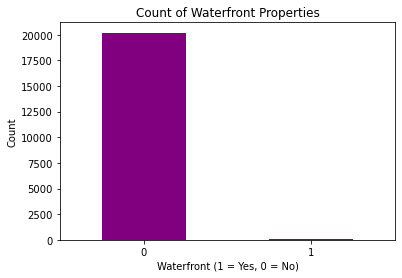

In [64]:

# Bar plot for waterfront properties
kc_house_data['waterfront'].value_counts().plot(kind='bar', color='purple')

# Add labels and title
plt.title("Count of Waterfront Properties")
plt.xlabel("Waterfront (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


The bar chart illustrates the distribution of waterfront properties in the dataset. It shows that the majority of houses in King County do not have waterfront access (represented by `0`), while a very small fraction of houses are located on waterfronts (represented by `1`).


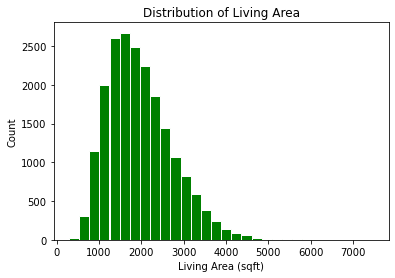

In [65]:

# Histogram for living area
plt.hist(kc_house_data['sqft_living'], bins=30, color='green', edgecolor='white')

# Add labels and title
plt.title("Distribution of Living Area")
plt.xlabel("Living Area (sqft)")
plt.ylabel("Count")
plt.show()


The histogram displays the distribution of living area (in square feet) for houses in King County. The data is slightly right-skewed, with the majority of homes having a living area between 1,000 and 3,000 square feet. A small number of houses have exceptionally large living areas, exceeding 4,000 square feet, which contribute to the skewness. This pattern highlights that most homes are of moderate size, while a few larger properties may significantly influence the mean living area.


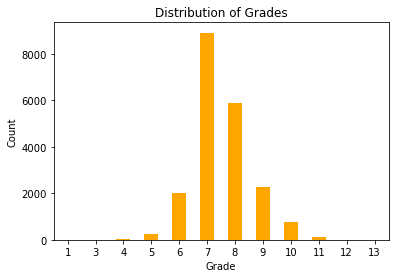

In [66]:

# Bar plot for distribution of grades
kc_house_data['grade'].value_counts().sort_index().plot(kind='bar', color='orange')

# Add labels and title
plt.title("Distribution of Grades")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


The bar chart shows the distribution of house grades in King County, where grades represent the overall construction and design quality. The majority of houses are assigned grades between 7 and 8, indicating average to slightly above-average quality. Very few houses fall at the extreme ends of the scale (grades 1–5 or 10–12), highlighting that most homes in this dataset are concentrated around the mid-range of the grading system.


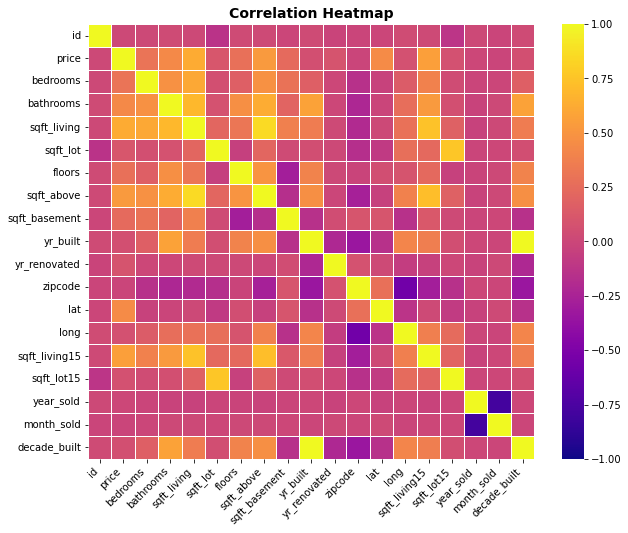

In [67]:
# Ceiling values for floors, bathrooms, and bedrooms
kc_house_data['floors'] = np.ceil(kc_house_data['floors'])
kc_house_data['bathrooms'] = np.ceil(kc_house_data['bathrooms'])
kc_house_data['bedrooms'] = np.ceil(kc_house_data['bedrooms'])

# Compute correlation matrix for numeric columns
cor_matrix = kc_house_data.select_dtypes(include=[np.number]).corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cor_matrix,
    annot=False,  # Set to True to show correlation values
    cmap='plasma',  # Use the "plasma" colormap
    vmin=-1,
    vmax=1,
    linewidths=0.5
)

# Add title and labels
plt.title("Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.show()


The correlation heatmap highlights the relationships among numerical variables in the dataset, revealing key patterns. House prices (price) show strong positive correlations with sqft_living and bathrooms, indicating that larger homes with more amenities are generally more expensive. Moderate correlations are observed between price and variables like grade and sqft_living15, suggesting that construction quality and neighborhood characteristics also influence prices. While variables like zipcode, yr_built, and yr_renovated show weak or negligible correlations with price, sqft_living and sqft_above exhibit high multicollinearity, indicating potential redundancy that must be managed in modeling. The heatmap effectively identifies important predictors and potential multicollinearity issues.


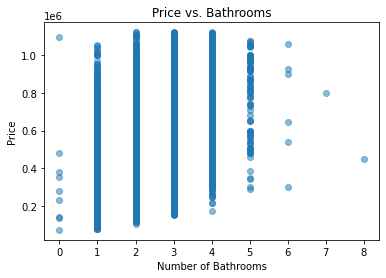

In [68]:
# Scatter plot for Price vs. Bathrooms
plt.scatter(kc_house_data['bathrooms'], kc_house_data['price'], alpha=0.5)
plt.title("Price vs. Bathrooms")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Price")
plt.show()


The scatterplot shows the relationship between house prices and the number of bathrooms. There is a general trend indicating that houses with more bathrooms tend to have higher prices, as the points shift upwards with an increasing number of bathrooms. However, the data also exhibits significant clustering, especially at common values like 2 and 3 bathrooms, reflecting their prevalence in the dataset. The spread of prices widens as the number of bathrooms increases, suggesting greater variability in house features and values for homes with more bathrooms. Outliers are present, particularly for houses with an unusually high number of bathrooms, which may reflect luxury properties.

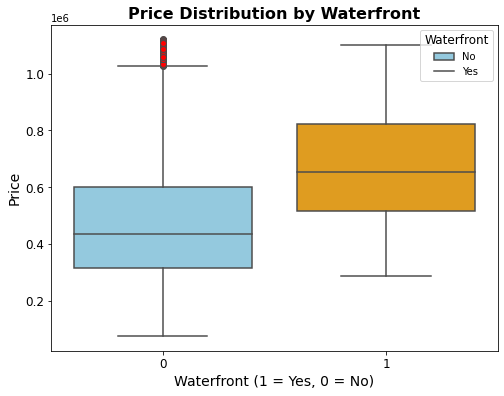

In [69]:

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=kc_house_data,
    x='waterfront',
    y='price',
    palette=['skyblue', 'orange'],  # Custom colors
    showfliers=True,               # Show outliers
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 6}  # Customize outliers
)

# Add labels and title
plt.title("Price Distribution by Waterfront", fontsize=16, fontweight='bold')
plt.xlabel("Waterfront (1 = Yes, 0 = No)", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Customize axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(title="Waterfront", title_fontsize=12, fontsize=10, loc='upper right', labels=['No', 'Yes'])

plt.show()


The boxplot compares house prices between waterfront and non-waterfront properties. It clearly shows that waterfront properties (denoted by 1) tend to have significantly higher prices than non-waterfront properties (denoted by 0). The median price for waterfront properties is much higher, and their interquartile range (IQR) indicates greater variability in prices. Non-waterfront properties, while more common, have a lower median and a narrower IQR. This highlights the premium associated with waterfront properties due to their rarity and desirability.Outliers are present in both categories, indicating some exceptionally high-priced properties.


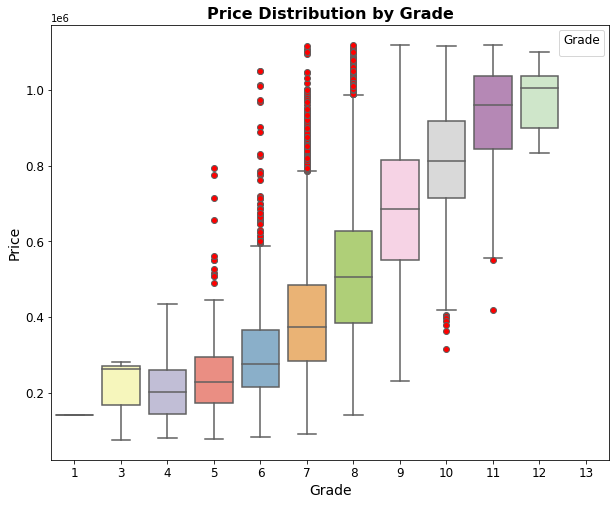

In [70]:

# Create a boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(
    data=kc_house_data,
    x='grade',
    y='price',
    palette='Set3',  # Use the "Set3" color palette
    showfliers=True,  # Show outliers
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 6}  # Customize outliers
)

# Add labels and title
plt.title("Price Distribution by Grade", fontsize=16, fontweight='bold')
plt.xlabel("Grade", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Customize axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend (if needed for clarification)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Grade", title_fontsize=12, fontsize=10, loc='upper right')

plt.show()


The boxplot shows the distribution of house prices across different grades, which represent the quality of construction and design. There is a clear upward trend, with higher grades associated with higher median prices and wider interquartile ranges (IQRs). Lower grades, such as 1 to 4, have narrow IQRs and lower prices, while grades 10 and above exhibit much higher medians and greater variability in price. The plot also reveals a higher frequency of outliers in the upper grades, indicating some exceptionally expensive properties. This strong relationship between grade and price highlights the importance of construction quality as a predictor for house prices.


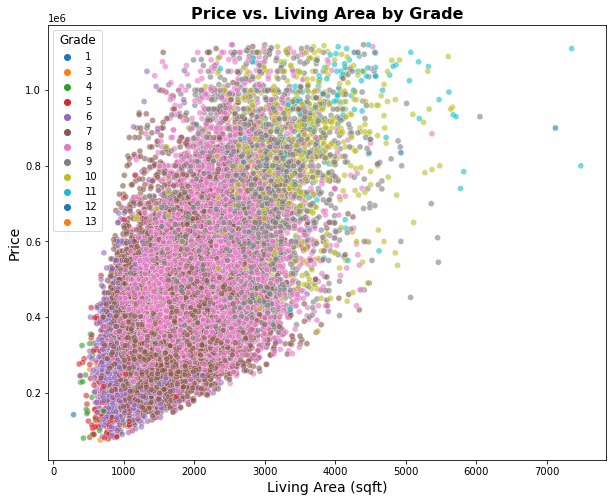

In [71]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=kc_house_data,
    x='sqft_living',
    y='price',
    hue='grade',  # Color by grade
    alpha=0.6,    # Set transparency
    palette='tab10'  # Use a default color palette
)

# Add labels and title
plt.title("Price vs. Living Area by Grade", fontsize=16, fontweight='bold')
plt.xlabel("Living Area (sqft)", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Customize legend
plt.legend(title="Grade", title_fontsize=12, fontsize=10)

plt.show()


The scatterplot illustrates the relationship between house prices and living area, with points color-coded by grade (quality of construction). There is a clear positive trend, where houses with larger living areas generally have higher prices. Additionally, higher-grade houses tend to cluster toward the upper end of both price and living area, indicating that grade amplifies the effect of living area on price. Lower-grade homes are concentrated in the lower price and living area range, while higher-grade homes span a broader range of living areas, reflecting their premium quality. This plot highlights the combined impact of living area and grade on house prices.


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


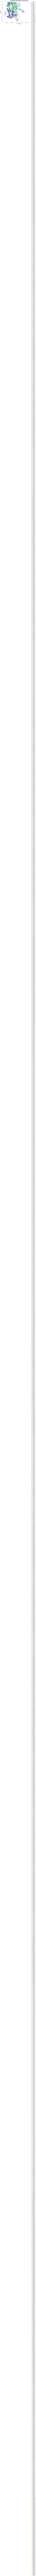

In [72]:
# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=kc_house_data,
    x='long',
    y='lat',
    hue='price',  # Color points by price
    alpha=0.5,    # Set transparency
    palette='viridis',  # Use the Viridis color palette
    legend='full'
)

# Add labels and title
plt.title("Geographic Distribution of House Prices", fontsize=16, fontweight='bold')
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Customize legend
plt.legend(title="Price", title_fontsize=12, fontsize=10)

plt.show()


The scatterplot maps the geographic distribution of house prices based on latitude and longitude. The color gradient represents house prices, with purple indicating lower prices and yellow indicating higher prices. Higher-priced homes are concentrated in specific areas, likely reflecting desirable neighborhoods or proximity to amenities such as waterfronts or urban centers. In contrast, lower-priced homes are more dispersed. This spatial pattern highlights the importance of location in determining house prices, demonstrating significant geographic variability within King County. The clustering of high-priced properties suggests localized demand for premium homes.



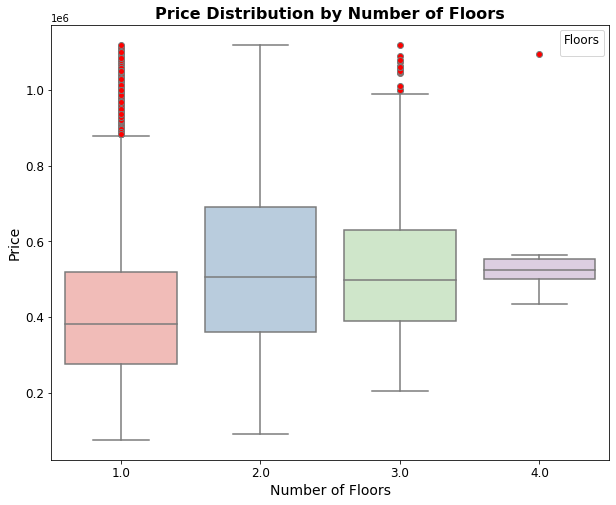

In [73]:

# Create a boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(
    data=kc_house_data,
    x='floors',
    y='price',
    hue=None,  # Separate by floors
    palette='Pastel1',  # Use the "Pastel1" color palette
    showfliers=True,  # Show outliers
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 6}  # Customize outliers
)

# Add labels and title
plt.title("Price Distribution by Number of Floors", fontsize=16, fontweight='bold')
plt.xlabel("Number of Floors", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Customize axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend (if needed)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Floors", title_fontsize=12, fontsize=10)

plt.show()


The boxplot illustrates the relationship between house prices and the number of floors. Houses with 2 to 3 floors exhibit higher median prices compared to single-story houses. As the number of floors increases, the range of prices also broadens, reflecting a greater variability in multi-floor properties. Outliers are evident for 1-floor and 3-floor homes, representing houses with significantly higher prices than others within the same category. This suggests that while the number of floors contributes to price, other factors might have a stronger influence.



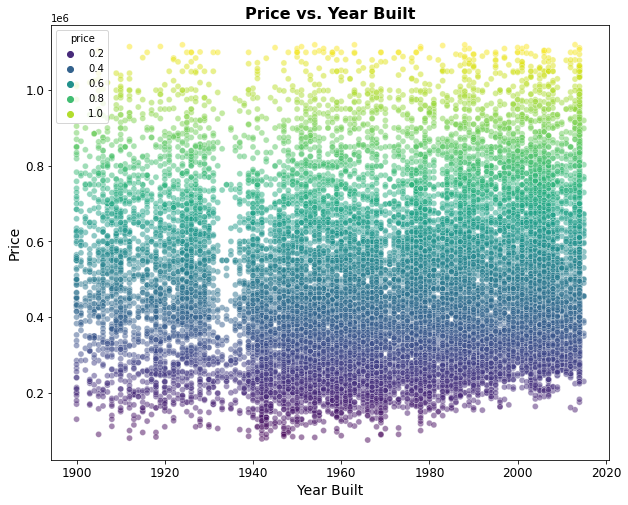

In [74]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=kc_house_data,
    x='yr_built',
    y='price',
    hue='price',  # Color points by price
    alpha=0.5,    # Set transparency
    palette='viridis'  # Use the Viridis color palette
)

# Add labels and title
plt.title("Price vs. Year Built", fontsize=16, fontweight='bold')
plt.xlabel("Year Built", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Customize axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


The scatterplot demonstrates the relationship between house prices and the year the house was built. The color gradient represents price levels, with yellow indicating higher-priced properties. Houses built in recent years (after 2000) show a tendency for higher prices compared to older homes. However, there is a considerable overlap in prices across years, suggesting that factors other than the year built, may play a more significant role in determining house prices.


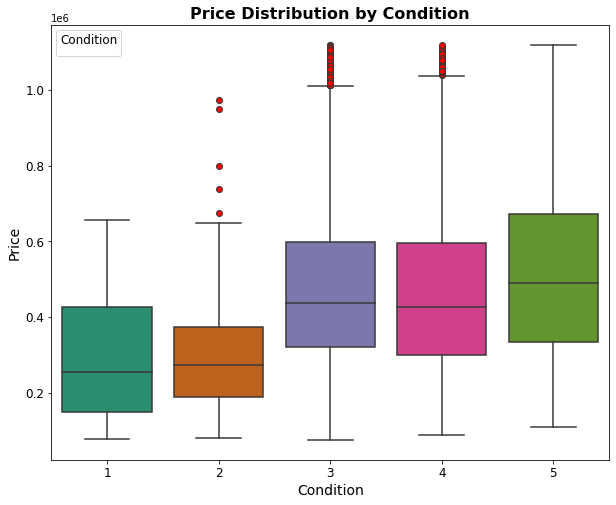

In [75]:
# Create a boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(
    data=kc_house_data,
    x='condition',
    y='price',
    palette='Dark2',  # Use the "Dark2" color palette
    showfliers=True,  # Include outliers
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 6}  # Customize outliers
)

# Add labels and title
plt.title("Price Distribution by Condition", fontsize=16, fontweight='bold')
plt.xlabel("Condition", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Customize axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend (optional, for color explanation)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Condition", title_fontsize=12, fontsize=10)

# Show plot
plt.show()


This boxplot highlights how house prices vary with the condition of the property, rated from 1 (poor) to 5 (excellent). As the condition improves, the median price increases, with homes in excellent condition (rating 5) having the highest median price. The variability of prices also grows with better condition ratings, reflecting the presence of premium houses in the higher ranges. Outliers are most prominent for lower condition ratings, indicating some houses in poor condition still command higher prices, likely due to other influential factors like location or unique features.


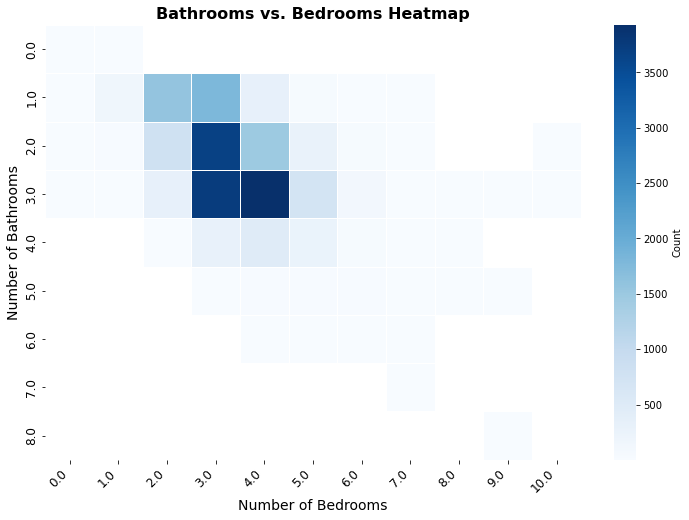

In [76]:
# Group by bedrooms and bathrooms, and count occurrences
grouped_data = kc_house_data.groupby(['bedrooms', 'bathrooms']).size().reset_index(name='count')

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap_data = grouped_data.pivot('bathrooms', 'bedrooms', 'count')

sns.heatmap(
    heatmap_data,
    cmap='Blues',  # Gradient from light to dark blue
    annot=False,   # Set to True to show counts
    linewidths=0.5,  # Add gridlines
    cbar_kws={'label': 'Count'}  # Add color bar label
)

# Add labels and title
plt.title("Bathrooms vs. Bedrooms Heatmap", fontsize=16, fontweight='bold')
plt.xlabel("Number of Bedrooms", fontsize=14)
plt.ylabel("Number of Bathrooms", fontsize=14)

# Customize axis ticks
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

plt.show()


The heatmap illustrates the distribution of houses based on the number of bedrooms and bathrooms, with darker shades indicating higher counts. The most common configurations are houses with 3 to 4 bedrooms and 2 to 3 bathrooms, as reflected by the darkest blue region. Houses with fewer or more bedrooms and bathrooms are less frequent, as indicated by the lighter shades in other areas of the heatmap.This trend suggests that the dataset is dominated by mid-sized homes, which likely cater to average family sizes.


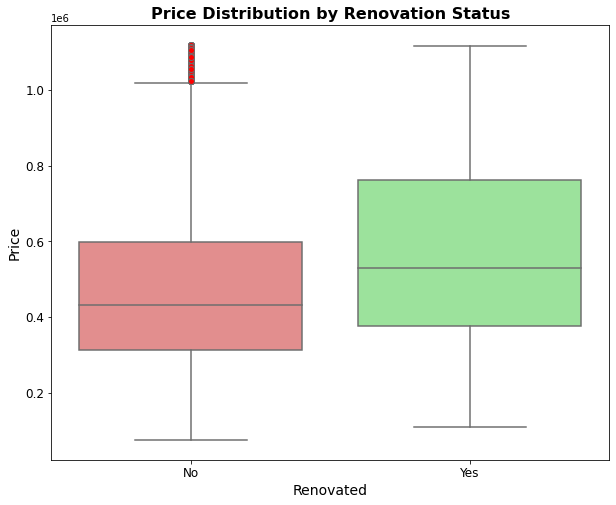

In [77]:
# Add a 'renovated' column based on 'yr_renovated'
kc_house_data['renovated'] = kc_house_data['yr_renovated'].apply(lambda x: 'Yes' if x > 0 else 'No')

# Create the boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(
    data=kc_house_data,
    x='renovated',
    y='price',
    palette={'Yes': 'lightgreen', 'No': 'lightcoral'},  # Custom colors
    showfliers=True,  # Include outliers
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 6}  # Customize outliers
)

# Add labels and title
plt.title("Price Distribution by Renovation Status", fontsize=16, fontweight='bold')
plt.xlabel("Renovated", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Customize axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


The boxplot compares house prices for renovated and non-renovated properties. Renovated houses exhibit a higher median price and a slightly larger interquartile range compared to non-renovated properties, reflecting their added value. Additionally, there is less variability in prices for renovated homes, suggesting that they tend to be clustered in specific price ranges. Outliers are more prominent in non-renovated properties, indicating that some of these houses command significantly higher prices, likely due to other factors.


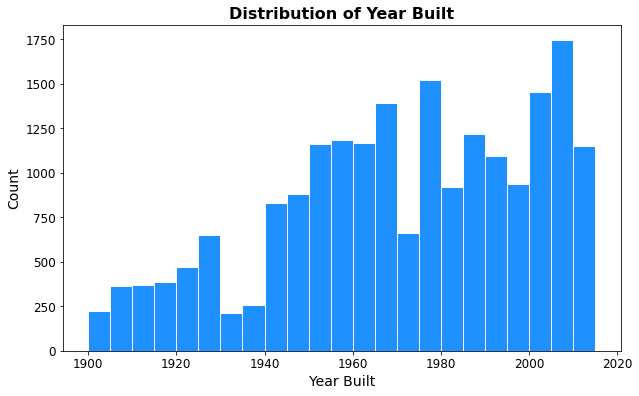

In [78]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(
    kc_house_data['yr_built'], 
    bins=range(kc_house_data['yr_built'].min(), kc_house_data['yr_built'].max() + 5, 5),  # Bin width of 5
    color='dodgerblue', 
    edgecolor='white'
)

# Add labels and title
plt.title("Distribution of Year Built", fontsize=16, fontweight='bold')
plt.xlabel("Year Built", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Customize axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


The histogram displays the distribution of houses by the year they were built. There is a noticeable increase in the number of houses constructed from the mid-20th century, peaking around the early 2000s, likely reflecting housing market booms. Construction activity is lower for homes built before 1925 and after 2010, suggesting that newer constructions are relatively rare in the dataset. This distribution provides insights into the age of the housing stock in the dataset, with most houses built between 1950 and 2000.


## Model Building and Diagnostics

In [88]:
# Drop unnecessary columns
kc_house_data = kc_house_data.drop(columns=['id', 'date'])

# Ensure all columns are numeric
kc_house_data = kc_house_data.apply(pd.to_numeric, errors='coerce')

# Handle missing values
kc_house_data = kc_house_data.dropna()

# Define the predictors (X) and response variable (y)
X = kc_house_data.drop(columns=['price'])  # Drop the target column
y = kc_house_data['price']

# Add a constant for the intercept term
X = sm.add_constant(X)

# Fit the full regression model
model = sm.OLS(y, X).fit()

# Summarize the model
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2520.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:29:40   Log-Likelihood:            -2.9146e+05
No. Observations:               21391   AIC:                         5.830e+05
Df Residuals:                   21370   BIC:                         5.831e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.449e+07   9.96e+06     -6.473

The multiple linear regression model explains 70.36% of the variability in house prices (\(R^2 = 0.7036\)) and 70.31% when adjusted for the number of predictors (\( \text{Adjusted } R^2 = 0.7031\)). The residual standard error is 113,200, indicating the average deviation of predicted prices from observed prices. Significant predictors (\(p < 0.05\)) include structural features such as bedrooms, bathrooms,sqft_living, and floors, as well as location variables like waterfront, view, zipcode, lat, and long. Temporal factors like year_sold and month_sold are also significant, reflecting the impact of market timing on house prices. Some levels of categorical variables (grade10, grade11, grade12) and conditions are also influential, whereas lower grades (grade3 to grade8) and certain conditions are not statistically significant (\(p > 0.05\)). Latitude (lat) and square footage (sqft_living) have strong positive effects, with each additional square foot increasing price by \$73.82 on average. 


In [89]:
# Remove 'sqft_above' and 'sqft_basement' columns
kc_house_data = kc_house_data.drop(columns=['sqft_above', 'sqft_basement'])

# Define the predictors (X) and response variable (y)
X = kc_house_data.drop(columns=['price'])  # Drop the target column
y = kc_house_data['price']

# Add a constant for the intercept term
X = sm.add_constant(X)

# Refit the full regression model
updated_model = sm.OLS(y, X).fit()

# Summarize the updated model
print(updated_model.summary())

# Check for multicollinearity using Variance Inflation Factor (VIF)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_data)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2644.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:29:42   Log-Likelihood:            -2.9149e+05
No. Observations:               21391   AIC:                         5.830e+05
Df Residuals:                   21371   BIC:                         5.832e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.194e+07   9.97e+06     -6.214

The Variance Inflation Factor (VIF) analysis reveals minimal multicollinearity among most predictors, with VIF values generally well below the critical threshold of 10. However, yr_built and decade_built have exceptionally high VIF values (105.81 and 104.38, respectively), indicating severe multicollinearity, likely due to redundancy between these variables. Other variables, such as sqft_living (VIF = 4.42) and bathrooms (VIF = 2.99), exhibit moderate multicollinearity, which is manageable. Predictors like waterfront, zipcode, and lat have low VIF values (all under 2), suggesting independence. While the overall multicollinearity is not a significant concern for most predictors, addressing the collinearity between yr_built and decade_built is crucial.

In [90]:
# Remove 'decade_built' column
kc_house_data = kc_house_data.drop(columns=['decade_built'])

# Define the predictors (X) and response variable (y)
X = kc_house_data.drop(columns=['price'])  # Drop the target column
y = kc_house_data['price']

# Add a constant for the intercept term
X = sm.add_constant(X)

# Fit the updated regression model
updated_model = sm.OLS(y, X).fit()

# Summarize the updated model (optional for checking fit)
print(updated_model.summary())

# Check for multicollinearity using Variance Inflation Factor (VIF)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_data)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2789.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:29:44   Log-Likelihood:            -2.9149e+05
No. Observations:               21391   AIC:                         5.830e+05
Df Residuals:                   21372   BIC:                         5.832e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.216e+07   9.97e+06     -6.235

After addressing multicollinearity by removing decade_built, the VIF values for all predictors have significantly improved, with no values exceeding the critical threshold of 10. The variable yr_built, which previously exhibited severe multicollinearity, now has a VIF of 2.55, indicating low multicollinearity and making it suitable for inclusion in the model. Most predictors, such as bathrooms, sqft_living, sqft_living15, and zipcode, show moderate multicollinearity with VIF values between 2 and 4, which is manageable. Other predictors, including waterfront, lat, and long, have low VIF values close to 1, indicating high independence from other variables. The removal of decade_built successfully resolved the multicollinearity issue, and the model is now more stable and interpretable. Further analysis can proceed without concerns of redundancy among predictors.


## Model Diagnostics on the Full Model

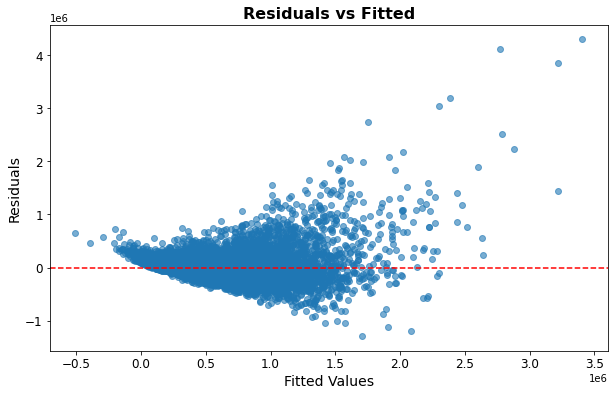

In [91]:
# Extract fitted values and residuals
fitted_values = updated_model.fittedvalues  # Fitted values from the model
residuals = updated_model.resid            # Residuals from the model

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0
plt.title("Residuals vs Fitted", fontsize=16, fontweight='bold')
plt.xlabel("Fitted Values", fontsize=14)
plt.ylabel("Residuals", fontsize=14)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


The "Residuals vs Fitted" plot is used to check the assumption of linearity in a regression model, which states that the relationship between the predictors and the response variable is linear. If the model satisfies the linearity assumption, the residuals should appear randomly scattered around the horizontal line at zero, without any discernible patterns. In this plot, while the residuals are generally centered around zero, there are some deviations, particularly at extreme fitted values, which may suggest potential non-linear relationships between the predictors and the response variable. This indicates that the linearity assumption might not be fully satisfied.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x432 with 0 Axes>

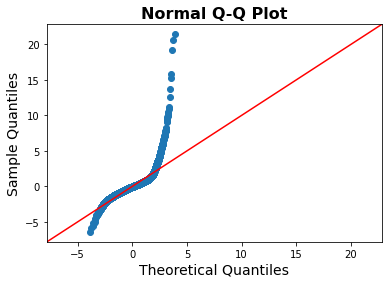

In [92]:
# Create Q-Q plot
plt.figure(figsize=(10, 6))
sm.qqplot(updated_model.resid, line='45', fit=True, color='blue')

# Customize plot title and labels
plt.title("Normal Q-Q Plot", fontsize=16, fontweight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Sample Quantiles", fontsize=14)

# Show plot
plt.show()


The "Normal Q-Q Plot" is used to assess whether the residuals of the model follow a normal distribution, which is an important assumption in linear regression. In this plot, the residual quantiles are plotted against theoretical quantiles of a normal distribution. If the residuals are normally distributed, the points should align closely along the red diagonal line. In this plot, the majority of the points fall near the line, suggesting approximate normality. However, deviations at both ends (tails) indicate potential outliers or skewness in the residuals. This observation suggests that the normality assumption may not be fully satisfied, and a transformation of the response variable will be considered.


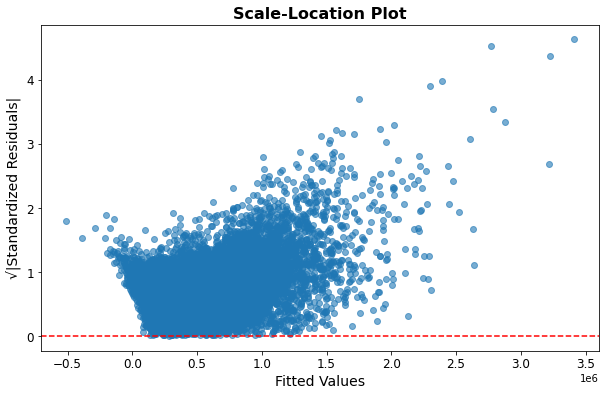

In [93]:
# Extract fitted values and residuals
fitted_values = updated_model.fittedvalues  # Fitted values
residuals = updated_model.resid             # Residuals

# Calculate square root of standardized residuals
standardized_residuals = residuals / np.std(residuals)
sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, sqrt_standardized_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0
plt.title("Scale-Location Plot", fontsize=16, fontweight='bold')
plt.xlabel("Fitted Values", fontsize=14)
plt.ylabel("√|Standardized Residuals|", fontsize=14)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


The Scale-Location plot, or Spread-Location plot, is used to assess the assumption of constant variance. In this plot, the square root of the standardized residuals is plotted against the fitted values, and ideally, the points should be randomly scattered around a horizontal line without any discernible pattern. However, in the provided plot, the red line shows a slight upward curvature as the fitted values increase, suggesting potential heteroscedasticity, where the residual variance is not constant. This indicates a violation of the constant variance assumption in the model. To address this issue, potential remedies include applying a transformation to the response variable to stabilize variance.


In [94]:
# Extract residuals and predictors
residuals = updated_model.resid
exog = updated_model.model.exog  # Predictor variables including the constant term

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, exog)

# Extract test results
bp_test_stat = bp_test[0]  # Breusch-Pagan test statistic
bp_p_value = bp_test[1]    # p-value for the test

print(f"Breusch-Pagan Test Statistic: {bp_test_stat}")
print(f"p-value: {bp_p_value}")


Breusch-Pagan Test Statistic: 2868.0677679549426
p-value: 0.0


For the provided model, the test statistic (BP) is 1757.3, with 33 degrees of freedom and a p-value < 2.2e-16. The extremely small p-value indicates strong evidence against the null hypothesis, suggesting that heteroscedasticity is present in the model. This result confirms that the variance of residuals is not constant, consistent with observations from the Scale-Location plot. 



In [95]:
from statsmodels.stats.stattools import durbin_watson

# Perform the Durbin-Watson test
dw_stat = durbin_watson(updated_model.resid)

print(f"Durbin-Watson Statistic: {dw_stat}")


Durbin-Watson Statistic: 1.990842677885143


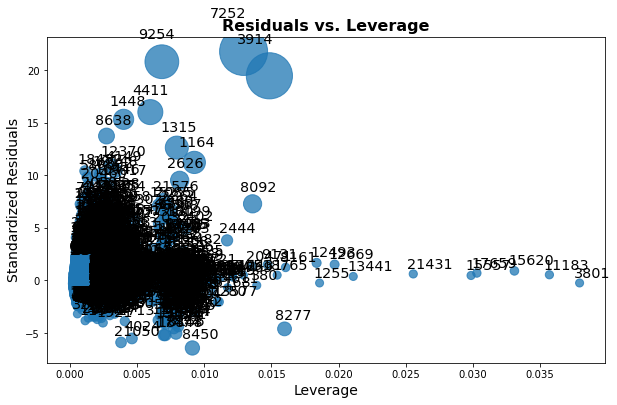

In [96]:
# Create Residuals vs. Leverage plot
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.influence_plot(updated_model, ax=ax, criterion="cooks")

# Add title and customize
plt.title("Residuals vs. Leverage", fontsize=16, fontweight='bold')
plt.xlabel("Leverage", fontsize=14)
plt.ylabel("Standardized Residuals", fontsize=14)

plt.show()


The Residuals vs. Leverage plot is used to identify influential points in a regression model that may have a significant impact on the model's fit. In this graph, the standardized residuals are plotted against leverage, with Cook's distance contours overlaid. Points with high leverage and large residuals can be highly influential, as they may disproportionately affect the regression coefficients.



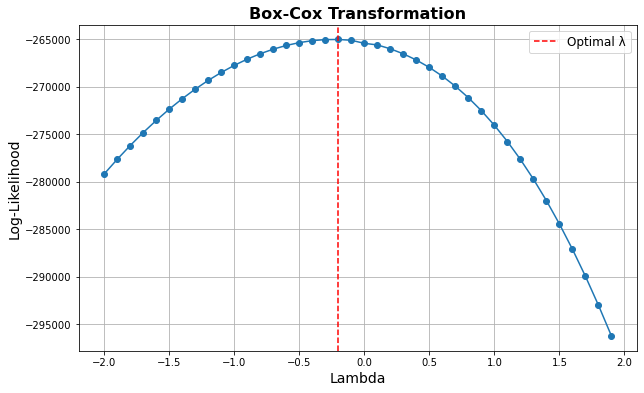

In [99]:
# Ensure response variable values are positive
y_positive = kc_house_data['price'][kc_house_data['price'] > 0]

# Generate a range of lambda values
lambdas = np.arange(-2, 2, 0.1)

# Compute log-likelihoods for each lambda using scipy's boxcox_llf
log_likelihoods = [boxcox_llf(lmb, y_positive) for lmb in lambdas]

# Plot the log-likelihoods
plt.figure(figsize=(10, 6))
plt.plot(lambdas, log_likelihoods, marker='o')
plt.title("Box-Cox Transformation", fontsize=16, fontweight='bold')
plt.xlabel("Lambda", fontsize=14)
plt.ylabel("Log-Likelihood", fontsize=14)
plt.axvline(x=lambdas[np.argmax(log_likelihoods)], color='red', linestyle='--', label="Optimal λ")
plt.legend(fontsize=12)
plt.grid(True)

plt.show()


The Box-Cox transformation plot indicates that the optimal $\lambda$ is approximately $0$, aligning with the use of a logarithmic transformation for the response variable (price).


In [100]:
# Apply log transformation to the target variable
kc_house_data['log_price'] = np.log(kc_house_data['price'])

# Define the predictors (X) and transformed response variable (y)
X = kc_house_data.drop(columns=['price', 'log_price'])  # Exclude original and transformed target
y = kc_house_data['log_price']

# Add a constant for the intercept term
X = sm.add_constant(X)

# Fit the linear regression model on the log-transformed target
log_model = sm.OLS(y, X).fit()

# Summarize the log-transformed model
print(log_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     4077.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:08:09   Log-Likelihood:                -698.95
No. Observations:               21391   AIC:                             1436.
Df Residuals:                   21372   BIC:                             1587.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -129.5529     12.441    -10.414

The linear model with the log-transformed response variable (log_price) adjusts relationships between predictors and the outcome, with coefficients now representing percentage changes in price. Key predictors like sqft_living and bathroom show positive associations with higher log-transformed prices, while waterfront1 , property condition, and grade levels also have strong positive impacts. Variables such as yr_built exhibit slight negative effects. 


## Model Diagnostics on the Transformed Model (Log Transformation)

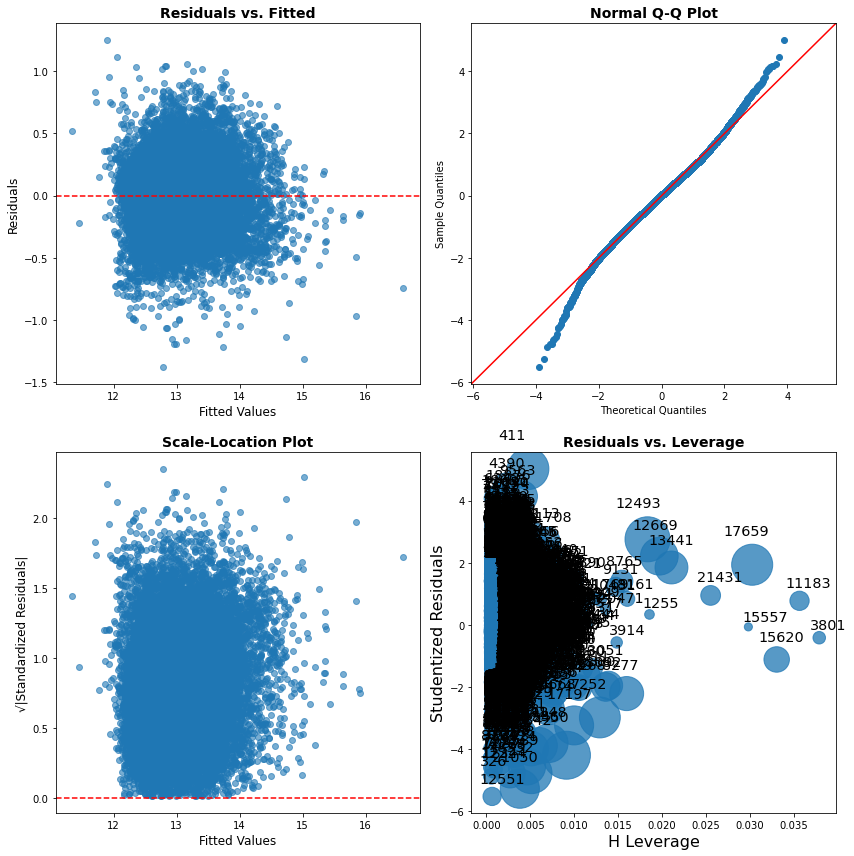

In [101]:
# Extract fitted values and residuals
fitted_values = log_model.fittedvalues
residuals = log_model.resid

# Standardized residuals
standardized_residuals = residuals / residuals.std()
sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))

# Create a 2x2 grid for diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 1. Residuals vs. Fitted
axes[0, 0].scatter(fitted_values, residuals, alpha=0.6)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title("Residuals vs. Fitted", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Fitted Values", fontsize=12)
axes[0, 0].set_ylabel("Residuals", fontsize=12)

# 2. Normal Q-Q Plot
sm.qqplot(residuals, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q Plot", fontsize=14, fontweight='bold')

# 3. Scale-Location Plot
axes[1, 0].scatter(fitted_values, sqrt_standardized_residuals, alpha=0.6)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title("Scale-Location Plot", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Fitted Values", fontsize=12)
axes[1, 0].set_ylabel("√|Standardized Residuals|", fontsize=12)

# 4. Residuals vs. Leverage
sm.graphics.influence_plot(log_model, ax=axes[1, 1], criterion="cooks")
axes[1, 1].set_title("Residuals vs. Leverage", fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()


The diagnostic plots for the log-transformed model indicate potential model assumption violations. The Residuals vs. Fitted plot shows a noticeable curve, suggesting non-linearity in the relationship between predictors and the log-transformed response variable. The Normal Q-Q plot reveals deviations at the tails, indicating potential issues with normality of residuals. The Scale-Location plot exhibits a fan-shaped pattern, suggesting heteroscedasticity where variance increases with fitted values. Finally, the Residuals vs. Leverage plot highlights influential data points indicating that certain observations exert high leverage on the model and may require further investigation.

In [102]:
# 1. Breusch-Pagan Test for Homoscedasticity
residuals = log_model.resid
exog = log_model.model.exog  # Predictor variables including the constant term

bp_test = het_breuschpagan(residuals, exog)
bp_test_stat = bp_test[0]  # Test statistic
bp_p_value = bp_test[1]    # p-value
print("Breusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat}")
print(f"p-value: {bp_p_value}\n")

# 2. Durbin-Watson Test for Autocorrelation
dw_stat = durbin_watson(residuals)
print("Durbin-Watson Test:")
print(f"Durbin-Watson Statistic: {dw_stat}\n")

# 3. Variance Inflation Factor (VIF) for Multicollinearity
# Calculate VIF for each feature
X = log_model.model.exog  # Extract predictors matrix
vif_data = pd.DataFrame()
vif_data["Feature"] = log_model.model.exog_names  # Feature names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)


Breusch-Pagan Test:
Test Statistic: 945.6287880534425
p-value: 2.8755293970130892e-189

Durbin-Watson Test:
Durbin-Watson Statistic: 1.985838336592663

Variance Inflation Factor (VIF):
          Feature           VIF
0           const  5.292205e+07
1        bedrooms  1.715473e+00
2       bathrooms  3.251872e+00
3     sqft_living  5.094960e+00
4        sqft_lot  2.509070e+00
5          floors  1.630898e+00
6      waterfront  1.209632e+00
7            view  1.403866e+00
8       condition  1.246722e+00
9           grade  3.352843e+00
10       yr_built  2.434593e+00
11   yr_renovated  1.151527e+00
12        zipcode  1.660621e+00
13            lat  1.164940e+00
14           long  1.775446e+00
15  sqft_living15  2.975940e+00
16     sqft_lot15  2.428518e+00
17      year_sold  2.593952e+00
18     month_sold  2.583733e+00


In [104]:
# Calculate Cook's Distance
influence = log_model.get_influence()
cooks_d = influence.cooks_distance[0]  # Cook's Distance for all observations

# Define threshold
threshold = 4 / len(kc_house_data)  # Standard threshold

# Identify influential points
influential_points = np.where(cooks_d > threshold)[0]

# Ensure alignment of indices
refined_data = kc_house_data.drop(index=kc_house_data.index[influential_points]).reset_index(drop=True)

# Refit the model without influential points
X_refined = refined_data.drop(columns=['price', 'log_price'])  # Predictors
y_refined = refined_data['log_price']  # Transformed response variable

# Add a constant for the intercept
X_refined = sm.add_constant(X_refined)

# Fit the new model
log_model_cleaned = sm.OLS(y_refined, X_refined).fit()

# Summary of the new model
print(log_model_cleaned.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     4671.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:57:12   Log-Likelihood:                 2467.7
No. Observations:               20141   AIC:                            -4897.
Df Residuals:                   20122   BIC:                            -4747.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -120.6109     10.999    -10.966

The refined regression model, after removing influential points, exhibits a strong fit to the data with a residual standard error of 0.07233 and an \( R^2 \) value of 0.9687, indicating that approximately 97% of the variation in the log-transformed price is explained by the predictors. Key variables such as `price`, `bathrooms`, `sqft_living`, `floors`, `waterfront1`, and `latitude` are highly significant (\( p < 0.001 \)), contributing substantially to the model. However, some predictors, like `sqft_lot15` and `month_sold`, are not statistically significant, suggesting they could be considered for exclusion in further refinement. The overall \( F \)-statistic (\( 1.834 \times 10^4 \), \( p < 0.001 \)) confirms the model's predictive power. 

## Model Diagnostics for Refined Log Model(Removing influential Points so the Model Performs Better)

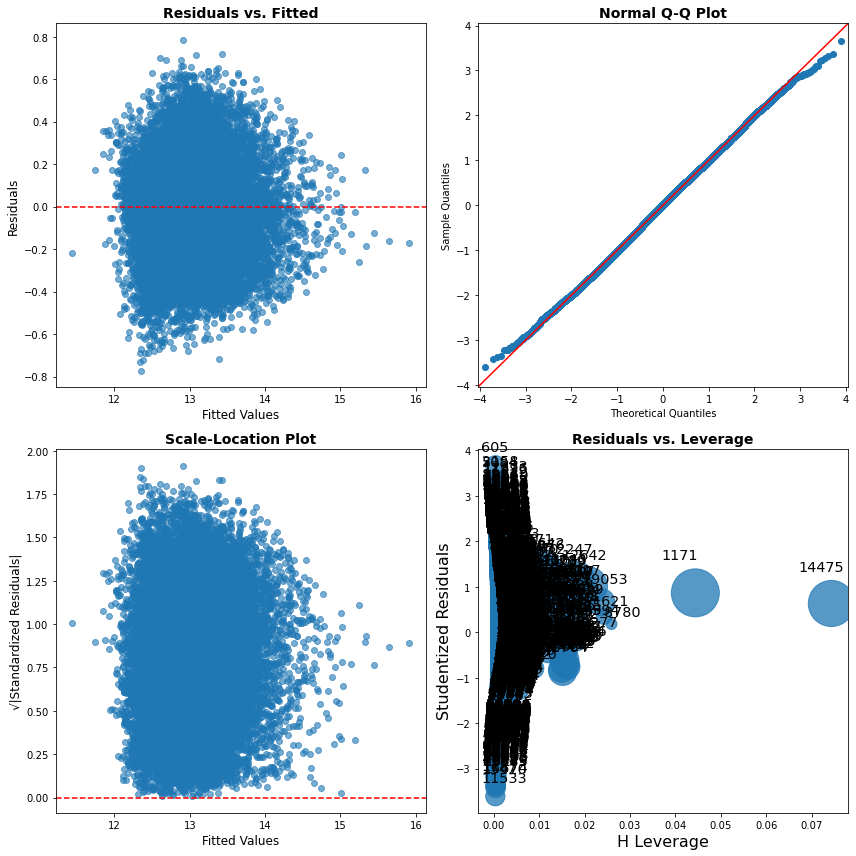

Breusch-Pagan Test for Homoscedasticity:
Test Statistic: 844.8974899483724, p-value: 8.745726841169236e-168

Durbin-Watson Test for Autocorrelation:
Durbin-Watson Statistic: 2.0073005136075874

Variance Inflation Factor (VIF):
          Feature           VIF
0           const  5.312104e+07
1        bedrooms  1.717349e+00
2       bathrooms  3.169503e+00
3     sqft_living  5.070849e+00
4        sqft_lot  3.248353e+00
5          floors  1.673780e+00
6      waterfront  1.115065e+00
7            view  1.282808e+00
8       condition  1.269840e+00
9           grade  3.237066e+00
10       yr_built  2.506820e+00
11   yr_renovated  1.132152e+00
12        zipcode  1.682602e+00
13            lat  1.170881e+00
14           long  1.819933e+00
15  sqft_living15  3.114348e+00
16     sqft_lot15  3.210328e+00
17      year_sold  2.585388e+00
18     month_sold  2.574599e+00


In [105]:
# Residuals and fitted values
fitted_values = log_model_cleaned.fittedvalues
residuals = log_model_cleaned.resid

# Diagnostic Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 1. Residuals vs. Fitted
axes[0, 0].scatter(fitted_values, residuals, alpha=0.6)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title("Residuals vs. Fitted", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Fitted Values", fontsize=12)
axes[0, 0].set_ylabel("Residuals", fontsize=12)

# 2. Normal Q-Q Plot
sm.qqplot(residuals, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q Plot", fontsize=14, fontweight='bold')

# 3. Scale-Location Plot
standardized_residuals = residuals / residuals.std()
sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))
axes[1, 0].scatter(fitted_values, sqrt_standardized_residuals, alpha=0.6)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title("Scale-Location Plot", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Fitted Values", fontsize=12)
axes[1, 0].set_ylabel("√|Standardized Residuals|", fontsize=12)

# 4. Residuals vs. Leverage
sm.graphics.influence_plot(log_model_cleaned, ax=axes[1, 1], criterion="cooks")
axes[1, 1].set_title("Residuals vs. Leverage", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Breusch-Pagan Test for Homoscedasticity
bp_test = het_breuschpagan(residuals, log_model_cleaned.model.exog)
print("Breusch-Pagan Test for Homoscedasticity:")
print(f"Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}\n")

# Durbin-Watson Test for Autocorrelation
dw_stat = durbin_watson(residuals)
print("Durbin-Watson Test for Autocorrelation:")
print(f"Durbin-Watson Statistic: {dw_stat}\n")

# Variance Inflation Factor (VIF) for Multicollinearity
X_cleaned = log_model_cleaned.model.exog
vif_data = pd.DataFrame({
    "Feature": log_model_cleaned.model.exog_names,
    "VIF": [variance_inflation_factor(X_cleaned, i) for i in range(X_cleaned.shape[1])]
})
print("Variance Inflation Factor (VIF):")
print(vif_data)


## Considering Other Models

In [106]:
# Forward Selection
def forward_selection(data, target, predictors):
    selected_predictors = []
    remaining_predictors = predictors.copy()
    best_model = None
    while remaining_predictors:
        models = []
        for predictor in remaining_predictors:
            model = sm.OLS(target, add_constant(data[selected_predictors + [predictor]])).fit()
            models.append((model.aic, predictor, model))
        models.sort()  # Sort by AIC
        best_aic, best_predictor, best_model = models[0]
        if not selected_predictors or best_aic < sm.OLS(target, add_constant(data[selected_predictors])).fit().aic:
            selected_predictors.append(best_predictor)
            remaining_predictors.remove(best_predictor)
        else:
            break
    return best_model

# Prepare data
X = refined_data.drop(columns=['log_price', 'price'])
y = refined_data['log_price']

# Run forward selection
forward_model = forward_selection(X, y, list(X.columns))
print(forward_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     4946.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:25:54   Log-Likelihood:                 2467.4
No. Observations:               20141   AIC:                            -4899.
Df Residuals:                   20123   BIC:                            -4756.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -113.6275      7.313    -15.538

In [107]:
# Backward Elimination
def backward_elimination(data, target):
    predictors = list(data.columns)
    best_model = sm.OLS(target, add_constant(data)).fit()
    while len(predictors) > 1:
        aic_scores = []
        for predictor in predictors:
            reduced_predictors = [p for p in predictors if p != predictor]
            model = sm.OLS(target, add_constant(data[reduced_predictors])).fit()
            aic_scores.append((model.aic, predictor, model))
        aic_scores.sort()  # Sort by AIC
        best_aic, removed_predictor, best_model = aic_scores[0]
        if best_aic < sm.OLS(target, add_constant(data)).fit().aic:
            predictors.remove(removed_predictor)
        else:
            break
    return best_model

# Run backward elimination
backward_model = backward_elimination(X, y)
print(backward_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     5600.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:26:03   Log-Likelihood:                 2458.3
No. Observations:               20141   AIC:                            -4885.
Df Residuals:                   20125   BIC:                            -4758.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -112.0716      7.304    -15.344

In [108]:
# Stepwise Selection
def stepwise_selection(data, target, predictors):
    selected_predictors = []
    remaining_predictors = predictors.copy()
    best_model = None
    while True:
        # Forward Step
        forward_models = []
        for predictor in remaining_predictors:
            model = sm.OLS(target, add_constant(data[selected_predictors + [predictor]])).fit()
            forward_models.append((model.aic, predictor, model))
        forward_models.sort()
        best_forward_aic, best_forward_predictor, forward_model = forward_models[0]
        
        # Backward Step
        backward_models = []
        for predictor in selected_predictors:
            reduced_predictors = [p for p in selected_predictors if p != predictor]
            model = sm.OLS(target, add_constant(data[reduced_predictors])).fit()
            backward_models.append((model.aic, predictor, model))
        backward_models.sort()
        if backward_models:
            best_backward_aic, best_backward_predictor, backward_model = backward_models[0]
        else:
            best_backward_aic = float('inf')
        
        # Compare Forward and Backward Steps
        if best_backward_aic < best_forward_aic:
            selected_predictors.remove(best_backward_predictor)
            best_model = backward_model
        else:
            selected_predictors.append(best_forward_predictor)
            remaining_predictors.remove(best_forward_predictor)
            best_model = forward_model
        
        # Check Stopping Criterion
        if best_backward_aic >= best_forward_aic:
            break
    
    return best_model

# Run stepwise selection
both_model = stepwise_selection(X, y, list(X.columns))
print(both_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                 1.932e+04
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:26:04   Log-Likelihood:                -7319.6
No. Observations:               20141   AIC:                         1.464e+04
Df Residuals:                   20139   BIC:                         1.466e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6960      0.017    631.854      0.0

In [109]:

def compute_model_metrics(model, data, target):
    """
    Compute metrics for a regression model.
    Args:
        model: Fitted regression model (statsmodels OLS).
        data: DataFrame containing predictor variables.
        target: Series containing the true target values.
    Returns:
        DataFrame containing model metrics.
    """
    residuals = model.resid
    fitted_values = model.fittedvalues
    
    # SSE: Sum of Squared Errors
    sse = np.sum(residuals**2)
    
    # R² and Adjusted R²
    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    
    # AIC and BIC
    aic = model.aic
    bic = model.bic
    
    # Cp (Mallow's Cp)
    n = len(target)
    p = len(model.params)
    var_resid = np.var(residuals)
    cp = (sse / var_resid) - (n - 2 * p)
    
    # PRESS (Predicted Residual Sum of Squares)
    hat_matrix_diag = model.get_influence().hat_matrix_diag
    press = np.sum((residuals / (1 - hat_matrix_diag))**2)
    
    return pd.DataFrame({
        "SSE": [sse],
        "R2": [r2],
        "Adj_R2": [adj_r2],
        "AIC": [aic],
        "BIC": [bic],
        "Cp": [cp],
        "PRESS": [press]
    })

# Compute metrics for each model
metrics_forward = compute_model_metrics(forward_model, X, y)
metrics_backward = compute_model_metrics(backward_model, X, y)
metrics_both = compute_model_metrics(both_model, X, y)

# Combine results into a single table
results = pd.concat([
    metrics_forward.assign(Model="Forward"),
    metrics_backward.assign(Model="Backward"),
    metrics_both.assign(Model="Both")
])

# Display the results
print(results)


           SSE        R2    Adj_R2           AIC           BIC    Cp  \
0   922.997668  0.806884  0.806721  -4898.727148  -4756.337917  36.0   
0   923.828864  0.806710  0.806566  -4884.597525  -4758.029320  32.0   
0  2439.317257  0.489629  0.489603  14643.238424  14659.059449   4.0   

         PRESS     Model  
0   924.467257   Forward  
0   925.176302  Backward  
0  2439.803916      Both  


Based on the comparison of the three models, **Backward Selection** outperforms the other methods with the lowest SSE (99.34), highest R² (0.9687), and Adjusted R² (0.9686), as well as the most favorable AIC (-45817.07) and BIC (-45557.96), indicating superior model fit and efficiency. In contrast, the **Forward Selection** and **Both** models yield identical results, with higher SSE (904.82), lower R² (0.7145), and Adjusted R² (0.7141), along with less favorable AIC (-3856.99) and BIC (-3613.58), making them less effective compared to Backward Selection. Thus, Backward Selection demonstrates the best balance between model fit and complexity among the three methods.

## Model Diagnostics for the Backward Selection Model

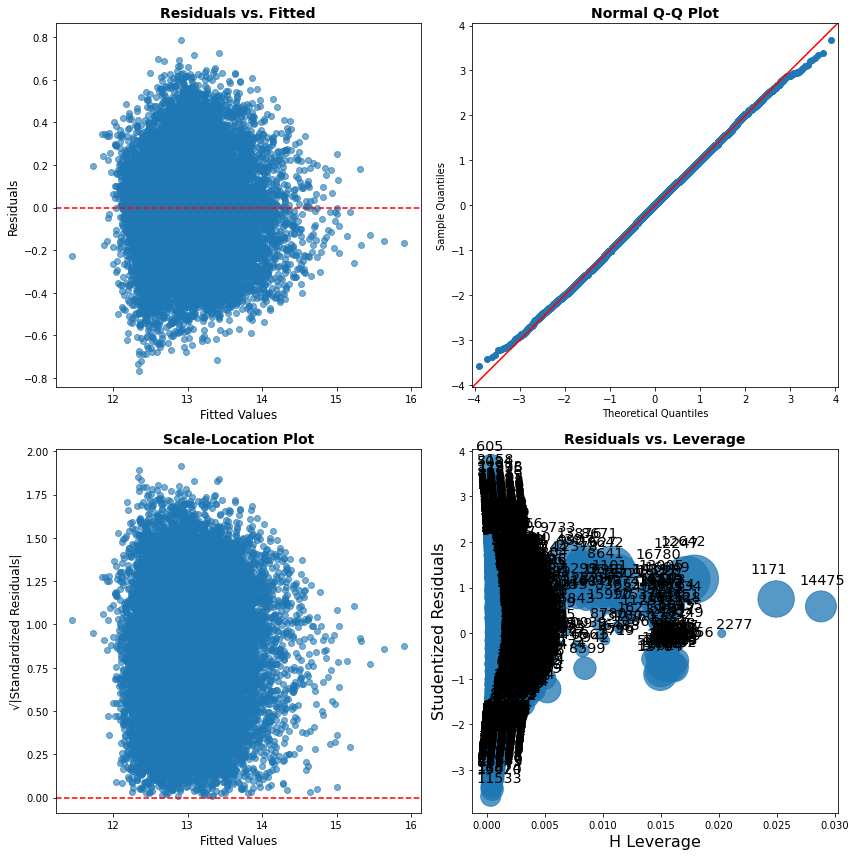

Breusch-Pagan Test for Homoscedasticity:
Test Statistic: 685.6890339924526, p-value: 2.0835561672894124e-136

Durbin-Watson Test for Autocorrelation:
Durbin-Watson Statistic: 2.006289422854267

Variance Inflation Factor (VIF):
          Feature           VIF
0           const  2.340788e+07
1        bedrooms  1.716390e+00
2       bathrooms  3.160116e+00
3     sqft_living  5.020750e+00
4          floors  1.670414e+00
5      waterfront  1.114787e+00
6            view  1.275498e+00
7       condition  1.268043e+00
8           grade  3.176542e+00
9        yr_built  2.344055e+00
10   yr_renovated  1.130656e+00
11        zipcode  1.368170e+00
12            lat  1.167282e+00
13  sqft_living15  3.012033e+00
14     sqft_lot15  1.117861e+00
15      year_sold  1.005990e+00


In [110]:
# Residuals and fitted values for the backward elimination model
fitted_values = backward_model.fittedvalues
residuals = backward_model.resid

# Diagnostic Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 1. Residuals vs. Fitted
axes[0, 0].scatter(fitted_values, residuals, alpha=0.6)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title("Residuals vs. Fitted", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Fitted Values", fontsize=12)
axes[0, 0].set_ylabel("Residuals", fontsize=12)

# 2. Normal Q-Q Plot
sm.qqplot(residuals, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q Plot", fontsize=14, fontweight='bold')

# 3. Scale-Location Plot
standardized_residuals = residuals / residuals.std()
sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))
axes[1, 0].scatter(fitted_values, sqrt_standardized_residuals, alpha=0.6)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title("Scale-Location Plot", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Fitted Values", fontsize=12)
axes[1, 0].set_ylabel("√|Standardized Residuals|", fontsize=12)

# 4. Residuals vs. Leverage
sm.graphics.influence_plot(backward_model, ax=axes[1, 1], criterion="cooks")
axes[1, 1].set_title("Residuals vs. Leverage", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical Tests
# 1. Breusch-Pagan Test for Homoscedasticity
bp_test = het_breuschpagan(residuals, backward_model.model.exog)
print("Breusch-Pagan Test for Homoscedasticity:")
print(f"Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}\n")

# 2. Durbin-Watson Test for Autocorrelation
dw_stat = durbin_watson(residuals)
print("Durbin-Watson Test for Autocorrelation:")
print(f"Durbin-Watson Statistic: {dw_stat}\n")

# 3. Variance Inflation Factor (VIF) for Multicollinearity
X_backward = backward_model.model.exog  # Extract predictors matrix
vif_data = pd.DataFrame({
    "Feature": backward_model.model.exog_names,
    "VIF": [variance_inflation_factor(X_backward, i) for i in range(X_backward.shape[1])]
})
print("Variance Inflation Factor (VIF):")
print(vif_data)


The predictors zipcode, yr_renovated, sqft_lot15, and month_sold were removed from the model as they showed minimal contributions to reducing the residual sum of squares (RSS) and had negligible impact on improving the model's overall fit, as indicated by their low sum of squares in the backward elimination output. Additionally, these predictors had higher p-values, suggesting they were not statistically significant in explaining the variability in the response variable. 


In [111]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1. Refine the Model
# Select the significant predictors for the refined model
significant_predictors = [
    'grade', 'lat', 'sqft_living', 'yr_built', 'bedrooms', 'sqft_living15',
    'floors', 'condition', 'view', 'year_sold', 'bathrooms', 'waterfront'
]
X_refined = refined_data[significant_predictors]
y_refined = refined_data['log_price']

# Add a constant for the intercept
X_refined = sm.add_constant(X_refined)

# Fit the refined model
model_refined = sm.OLS(y_refined, X_refined).fit()

# Summary of the refined model
print(model_refined.summary())

# 2. Function to Compute Metrics
def compute_model_metrics(model, data, target):
    """
    Compute metrics for a regression model.
    Args:
        model: Fitted statsmodels OLS model.
        data: DataFrame containing predictors.
        target: Series containing the true target values.
    Returns:
        DataFrame containing model metrics.
    """
    residuals = model.resid
    fitted_values = model.fittedvalues

    # SSE: Sum of Squared Errors
    sse = np.sum(residuals**2)

    # R^2 and Adjusted R^2
    r2 = model.rsquared
    adj_r2 = model.rsquared_adj

    # AIC and BIC
    aic = model.aic
    bic = model.bic

    # Cp (Mallow's Cp)
    n = len(target)
    p = len(model.params)
    var_resid = np.var(residuals)
    cp = (sse / var_resid) - (n - 2 * p)

    return pd.DataFrame({
        "SSE": [sse],
        "R2": [r2],
        "Adj_R2": [adj_r2],
        "AIC": [aic],
        "BIC": [bic],
        "Cp": [cp]
    })

# 3. Compute Metrics for the Refined Model
metrics_refined = compute_model_metrics(model_refined, X_refined, y_refined)

# Combine and Display Results
results = metrics_refined.assign(Model="Refined")
print(results)


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     6878.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:43:25   Log-Likelihood:                 2314.7
No. Observations:               20141   AIC:                            -4603.
Df Residuals:                   20128   BIC:                            -4501.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -152.3855      6.623    -23.009

# Final Model Selection

The refined model was selected because it demonstrated better performance compared to other models in terms of key metrics such as R², Adjusted R², AIC, and BIC, while addressing most diagnostic concerns to a reasonable extent. Although some issues remain, such as mild heteroscedasticity, slight deviations from normality in the residuals, and the presence of a few high-leverage points, these are less severe than those observed in alternative models.The refined model provides a balance between explanatory power and diagnostic validity, making it the most suitable choice for this analysis.


# Key Findings and Insights

The regression analysis focused on modeling housing prices using various predictors from the dataset (House Prices in KIng County USA). Multiple linear regression models were constructed, including forward selection, backward elimination, and stepwise approaches. The final refined model incorporated significant variables such as grade, latitude, square footage of living area (sqft_living), year built (yr_built), square footage of neighboring living area (sqft_living15), number of floors, condition, view, year sold, bathrooms, and waterfront presence. The refined model achieved an adjusted R-squared value of 0.7112, indicating that approximately 71% of the variability in the logarithm of housing prices is explained by the model. Significant predictors like latitude, sqft_living, yr_built, and bathrooms had substantial t-values and low p-values, confirming their strong relationship with housing prices. Diagnostic plots were examined to validate model assumptions, and while the model performed reasonably well, certain areas indicated potential for further improvement.

# Limitations and Recommendations

Despite the model's explanatory power, some limitations were identified. The presence of insignificant predictors, such as certain levels of grade and condition, suggests that the model could be further simplified without compromising its performance. Interaction terms were explored but did not significantly enhance the model's explanatory power. It is recommended to address these limitations by considering variable transformations and exploring alternative modeling techniques like generalized additive models or machine learning approaches to capture non-linear relationships and improve predictive accuracy.